## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,gen,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [1]:
# numerics + rv stuff
import numpy as np
import scipy as sp
from scipy.stats.distributions import chi2
from scipy.sparse import coo_matrix
from scipy.sparse import linalg
from numpy.random import default_rng
import moments
import dadi 
import Selection
# plotting + misc tools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
import seaborn
from matplotlib import cm 

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
N = 10000
s = -10/N # 25/N -> gamma2 = 50 - strong selection
mu = 1.25e-8 # human mutation rate
n = 2000 # 2 * # of inds sampled, diploid

# start in generation 10 so generation 11 has all zeros (going back in time)
tot_gen = 10000
time_steps = np.linspace(0, tot_gen-1, 100, dtype=int)

mom = np.zeros((tot_gen+1,n+1))
momnp1 = np.zeros(n+1)
momkp1 = np.zeros((tot_gen+1,n+1))

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

In [3]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [4]:
# code borrowed from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx  
def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

In [ ]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*mu # singleton input

J = calcJK13(n)

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:
    momkp1[gen,iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

    momkp1[gen,1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
    momkp1[gen,n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

    # notice the difference in indexing for LHS
    # momnp1[np.arange(1,n+1)] = (jk13[:,0] * mom[gen+1,np.array(ibis)-1] - jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1])
    momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

    momkp1[gen,iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

    mom[gen,] = deepcopy(momkp1[gen,])

mom2 = deepcopy(mom)

In [ ]:
## code to run APR's moments and compare with output from above
# initialize the spectrum, with 1 in singleton bin
fs = moments.Spectrum(np.zeros(2*n + 1))
fs[1] = n*1
# simulate a generations
T = tot_gen / 2 / N
# set relative size to 1, theta to 0 to forbid new mutations
fs.integrate([1], T, gamma=s*2*N, h=0.5, theta=0, adapt_dt=True, dt_fac=0.005)

In [5]:
## testbed for a single realization of gen = t & the Crank-Nicolson method
mom[100,1] = n*1 # singleton input

dt = 1

D = 0.25/N * calcD(n+1)
J = calcJK13(n+1)
S = 0.5 * s * calcS(n+1, J)

# if N is same across all gens then only have to do this once
slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - dt / 2.0 * (D + S))
Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + dt / 2.0 * (D + S)

# going from generation 9 to 0
for gen in np.arange(100)[::-1]:

    # momkp1[gen,iter] = mom[gen+1,iter] + ((D[iter,] + S[iter,]) @ mom[gen+1,])
    momkp1[gen,iter] = mom[gen+1,iter] + slv(Q.dot(mom[gen+1,iter]))
    momkp1[gen,0] = momkp1[gen,n] = 0.0

    mom[gen,] = deepcopy(momkp1[gen,])

NameError: name 'calcD' is not defined

In [6]:
def calcD(d):
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        if i > 1:
            data.append((i-1) * (d-i))
            row.append(i)
            col.append(i - 1)
        if i < d - 2:
            data.append((i+1) * (d-i-2))
            col.append(i + 1)
            row.append(i)
        if i > 0 and i < d - 1:
            data.append(-2 * i * (d-i-1))
            row.append(i)
            col.append(i)

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [7]:
def calcS(d, ljk):
    # Computes the jackknife-transformed selection matrix 1
    # for the addition of a single sample
    # arrays for the creation of the sparse (coo) matrix
    # data will have matrix entry, row + column have coordinates
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        i_bis = index_bis(i, d - 1) # This picks the second jackknife index 
        i_ter = index_bis(i + 1, d - 1) # This picks the third jackknife index
        # coefficients of the selection matrix
        g1 = i * (d-i) / np.float64(d)
        g2 = -(i+1) * (d-1-i) / np.float64(d)

        if i < d - 1 and i > 0: # First deal with non-fixed variants
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                    g1 * ljk[i - 1, i_bis], g2 * ljk[i, i_ter - 1],
                    g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 6 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1,
                    i_ter, i_ter - 1, i_ter + 1]
        
        elif i == 0: # g1=0
            data += [g2 * ljk[i, i_ter - 1],
                     g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 3 * [i]
            col += [i_ter, i_ter - 1, i_ter + 1]
        
        elif i == d - 1: # g2=0
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                     g1 * ljk[i - 1, i_bis]]
            row += 3 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1]

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [8]:
## packaging into a function for easy manipulation - iteration implementation 
# input: a (number of gens), n (number of samples), s, N (pop size)
# output: mom (number of sites)
def run_mom_iterate(a, n, s, N, mu, misc):
    mom = np.zeros((a+1,n+1))
    # momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    D = 0.25/N * calcD(n+1)
    J = calcJK13(n)
    S = 0.5 * s * calcS(n+1, J)

    # if N is same across all gens then only have to do this once
    slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - 0.5 * (D + S))
    Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + 0.5 * (D + S)

    mom[a,1] = 1 # singleton input

    # going from generation 9 to 0
    for gen in np.arange(a)[::-1]:
        # momkp1[iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

        # momkp1[1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
        # momkp1[n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

        # # notice the difference in indexing for LHS
        # momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

        # momkp1[iter] += 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])
        
        # momkp1[1:n] = mom[gen+1,1:n] + ((D[1:n,1:n] + S[1:n,1:n]) @ mom[gen+1,1:n])

        momkp1 = slv(Q.dot(mom[gen+1,]))
        momkp1[0] = momkp1[n] = 0.0

        mom[gen,] = deepcopy(momkp1)

    return n*mu*mom[:-1,:]           

In [9]:
def run_mom_iterate_changing(n, s, Nc, mu, misc):
    mom = np.zeros((len(Nc)+1,n+1))
    # momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    changepoints = len(Nc) - np.concatenate((np.array([0]),np.where(Nc[:-1] != Nc[1:])[0]+1),axis=0)
    changepoints = np.append(changepoints, 0)

    mom[len(Nc),1] = 1 # singleton input
    
    # only need to do this once - no dependence on N
    J = calcJK13(n)
    S = 0.5 * s * calcS(n+1, J)

    for i in range(len(changepoints)-1):
        D = 0.25/Nc[len(Nc)-changepoints[i]] * calcD(n+1)

        slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - 0.5 * (D + S))
        Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + 0.5 * (D + S)

        for gen in np.arange(changepoints[i+1],changepoints[i])[::-1]:
            momkp1 = slv(Q.dot(mom[gen+1,]))
            momkp1[0] = momkp1[n] = 0.0

            mom[gen,] = deepcopy(momkp1)

    return n*mu*mom[:-1,:]           

In [ ]:
## starting from the past to the present (Nc[-1] is current generation)
# Nc = np.concatenate((np.repeat(20000,10000),np.repeat(2000,2000)))
# changepoints = len(Nc) - np.concatenate((np.array([0]),np.where(Nc[:-1] != Nc[1:])[0]+1),axis=0)
# mom_outc = run_mom_iterate_changing(1000, -0.000125, Nc, mu, None)
# plt.imshow(mom_outc[10000:12000,:],aspect='auto',norm=colors.LogNorm(vmax=1e-4,vmin=1e-7)); plt.colorbar(); plt.show()
# plt.imshow(mom_outc/np.sum(mom_outc),aspect='auto',norm=colors.LogNorm(vmin=1e-10)); plt.colorbar(); plt.show()

In [ ]:
# fs = run_mom_integrate(4000, 1000, 0.5*gamma[0]/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
# plt.imshow(fs[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
# fs2 = run_mom_integrate2(4000, 200, 0.5*gamma[0]/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
# plt.imshow(fs2[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
mom = run_mom_iterate(8000, 2000, 0.5*gamma[10]/N, N, mu, np.nan)
plt.imshow(mom[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
# fs.shape, mom.shape
# plt.scatter(np.ravel(mom[:,1:-1]), np.ravel(fs[:,1:-1]), color='grey', alpha=0.75, s=5); plt.loglog()
# plt.axline((0,0),(1,1),color='red',ls='--', linewidth=0.6); plt.xlabel('iterative framework'); plt.ylabel('integrative framework'); plt.title('γ = {}'.format(-100.))

In [61]:
## function where each generation was integrated to separately
def run_mom_integrate(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    for idt, dt in enumerate(np.linspace(0.5/N,0.5*a/N,a)[::-1]):
        fs = moments.Spectrum(np.zeros(n + 1))
        fs[1] = 1
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = n*mu*fs
    return fsmat

## function where each generation is only integrated from previous generation
def run_mom_integrate2(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    dt = 0.5/N
    fs = moments.Spectrum(fsmat[-1,:])
    fs[1] = 1
    fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0)
    fsmat[-1,:] = fs
    for idt in np.arange(0,a-1)[::-1]:
        # fs = moments.Spectrum(fsmat[idt+1,:])
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = fs
    return n*mu*fsmat

In [12]:
## creating a database of P(X, a | s) with dicts for different s values
# import io
# up_xa_s = h5py.File(io.BytesIO(), 'w')
gamma2 = -np.logspace(-0.5,2.5,30)
up_xa_s = dict.fromkeys(gamma2)
## use different lengths of time for each gamma (high gamma - small limits)
## go up to 5 orders of magnitude below start (i.e., E[# seg sites] < 1e-11)
# limal = np.concatenate((np.linspace(7500,85000,20,dtype=int),np.repeat(85000,30)))
# limal = np.linspace(80000,5000,20,dtype=int)
for ig, g in enumerate(gamma2):
    # unscaled probability - almost likelihood
    up_xa_s[g] = run_mom_iterate(80000, 2000, 0.5*g/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # can project down to any sample size using moments.Spectrum(p_xa_s[g][-1,:]).project([20])*120/20

In [64]:
testup_xa_s = {}
testup_xa_s[gamma[6]] = run_mom_integrate(80000, 2000, 0.5*g/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

[]

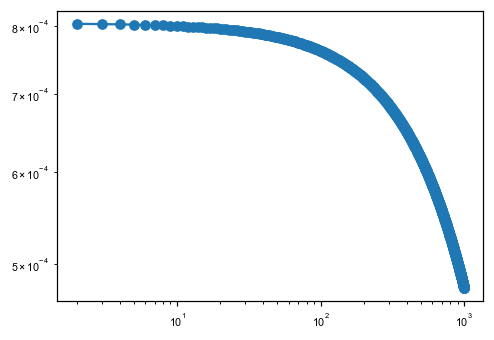

In [154]:
# testup_xa_s[gamma[6]][:,np.arange(cutoff,n-cutoff+1)] = testup_xa_s[gamma[6]][:,np.arange(cutoff,n-cutoff+1)]/np.sum(testup_xa_s[gamma[6]][:,np.arange(cutoff,n-cutoff+1)])
fs = moments.Spectrum(np.zeros(2000 + 1))
fs[1] = 1
fs.integrate([1], 120000/2/N, gamma=gamma[-1], theta=0, adapt_dt=True, dt_fac=0.0001)
testp_xa_s = fs
testp_xa_s[cutoff:(2000-cutoff+1)] = fs[cutoff:(2000-cutoff+1)]/np.sum(fs[cutoff:(2000-cutoff+1)])
plt.plot(np.arange(2,1001),testp_xa_s[2:1001],marker='o'); plt.loglog()
# testp_xa_s = np.sum(testup_xa_s[gamma[6]], axis=0)

Spectrum([-- 5.531784385398576e-38 5.411052503651587e-38 ... 3.7141418900092836e-53
 3.709722075003993e-53 --], folded=False, pop_ids=None)

In [ ]:
# import io
# up_xa_s = h5py.File(io.BytesIO(), 'w')
# up_xa_s.create_dataset("-1.",data=run_mom_iterate(limal[-1], 2000, -0.5/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True}))
# up_xa_s.create_dataset("-100.",data=run_mom_iterate(limal[0], 2000, -500./N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True}))

In [ ]:
## took 19 hours for first 13 gamma values - estimate: approx 3 days for all gamma values (since smaller ones take longer)
## using fs.integrate...
## iterate only takes 2 mins
# with open('testdata/fsintegrate.pkl', 'wb') as f:
#     pkl.dump(up_xa_s, f)

In [ ]:
## loading it back
# import pickle as pkl
# with open('testdata/fsintegrate.pkl', 'rb') as f:
#     up_xa_s = pkl.load(f)

In [ ]:
# import sys
# check size of different data objects
# up_xa_s = {}
# for ig, g in enumerate(gamma):
#     up_xa_s[g] = np.random.randn(n*limal[ig]).reshape((n,limal[ig]))
# sys.getsizeof(up_xa_s)

In [ ]:
# use these plots to figure out when to stop (for gamma<1, ok could stop at 10k for high gamma)
plt.scatter(np.arange(100000)[::-1],(np.sum(up_xa_s[-1.],axis=1)),alpha=0.7,color='k')
plt.scatter(np.arange(100000)[::-1],(np.sum(up_xa_s[-.1],axis=1)),alpha=0.7,color='grey')
plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')

In [13]:
## scaling the matrix from above to get pdf (all rows sum to 1)
cutoff = 2 # 2 x # of inds
for g in gamma2:
    # normalizing by rows (summing across gens)
    # p_xa_s[g] = up_xa_s[g]/up_xa_s[g].sum(axis=0,keepdims=1)
    # normalizing by rows and cols (summing across gens and # of derived alleles)
    # p_xa_s[g] = up_xa_s[g]/np.sum(up_xa_s[g])
    # normalizing by rows and cols and number of derived alleles (based on if detectable in sample or not)
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    # normalizing by rows (summing across allele freqs)
    # up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)].sum(axis=1,keepdims=True)

# import pickle as pkl
# with open('testdata/fsintegrate.pkl', 'wb') as f:
#     pkl.dump(up_xa_s, f)

In [14]:
## summing across rows and then normalizing to get P(X|\gamma) 
# already been normalized above so just need to sum across rows/gens
p_xa_s = {}
for g in gamma2:
    p_xa_s[g] = np.sum(up_xa_s[g], axis=0)

In [ ]:
## projecting the moments to a smaller sample size & then scaling (optional)
# ss = 20 # small sample
# pp_xa_s = {}
# for g in gamma:
#     pp_xa_s[g] = np.zeros((up_xa_s[g].shape[0],ss))
#     for i in range(up_xa_s[g].shape[0]):
#         pp_xa_s[g][i,:] = moments.Spectrum(up_xa_s[g][i,:]).project([ss]) * 150/ss
#     pp_xa_s[g] = pp_xa_s[g]/pp_xa_s[g].sum(axis=0,keepdims=1)

In [ ]:
plt.imshow(up_xa_s[gamma[15]],aspect='auto',norm=colors.LogNorm(vmax=1e-7,vmin=1e-20)); plt.colorbar()
# np.min(p_xa_s[gamma[4]][10,:])

### Reading in simulation data for comparison

In [14]:
df2 = pd.read_csv("../traindata/trip-2022-03-29.csv")
df2['gamma'] = df2['gamma'].round(decimals=2)
df2['empty'] = ''
df2['empty2'] = ''
df2['sXl'] = rng.binomial(n=n, p=df2['Xl'])
gamma = np.unique(df2['gamma'])

In [15]:
# df1['sXl'] = np.around(df1['Xl']*n).astype(int)
nsites = 1000
idx2keep = np.empty(len(gamma)*nsites,dtype='int')
for ig, _ in enumerate(gamma):
    idx2keep[(ig*nsites):(ig+1)*nsites] = rng.choice(np.where(df2['sXl'][(ig*5000):(ig+1)*5000]>1)[0], nsites, False) + ig*5000
df2 = df2.iloc[idx2keep,:]
dat2 = df2.to_numpy()
df2

,Xl,gamma,al,empty,empty2,sXl
4741,0.002050,-100.0,1311.0,,,7
2469,0.004550,-100.0,134.0,,,12
718,0.004250,-100.0,42.0,,,3
1684,0.003500,-100.0,327.0,,,7
1441,0.001550,-100.0,40.0,,,2
...,...,...,...,...,...,...
99056,0.019750,-1.0,1764.0,,,40
97494,0.056100,-1.0,6145.0,,,104
99727,0.401025,-1.0,48293.0,,,798
98331,0.044675,-1.0,4486.0,,,85


In [66]:
df1

,Xl,s,al,id,empty,sXl
0,0.0005,-1.0,1,50003174.0,,1
1,0.0055,-1.0,564,49721655.0,,11
2,0.0015,-1.0,17,49995042.0,,3
3,0.005,-1.0,63,49972181.0,,10
4,0.003,-1.0,146,49930441.0,,6
...,...,...,...,...,...,...
19995,0.001,-100.0,64,49962764.0,,2
19996,0.0015,-100.0,488,49750645.0,,3
19997,0.0005,-100.0,213,49888502.0,,1
19998,0.001,-100.0,84,49952830.0,,2


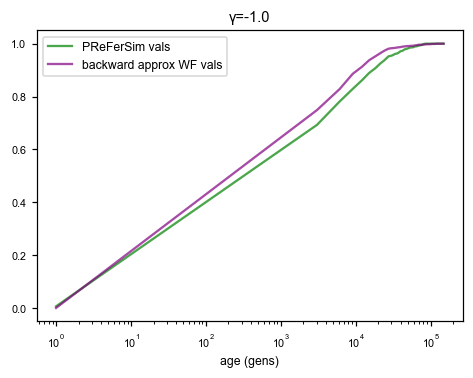

In [236]:
from statsmodels.distributions.empirical_distribution import ECDF
## PReFerSim selection coefficient is HALF of backward WF sims (need to test this further—simple to rerun cell, but long runtime)
def plot_ecdf_al_sxl(idx):
    indices = np.arange((19*1000),(19+1)*1000)
    indices2 = np.arange((16*1000),(16+1)*1000)
    age1_ecdf = ECDF(df1['al'][::-1].iloc[indices])
    age2_ecdf = ECDF(df2['al'].iloc[indices2])
    x = np.linspace(1,np.max(df2['al'].iloc[indices]))
    y1 = age1_ecdf(x)
    y2 = age2_ecdf(x)
    plt.plot(x, y1, color='green', alpha=0.7, label='PReFerSim vals'); plt.xlabel('age (gens)'); plt.semilogx()
    plt.plot(x, y2, color='purple', alpha=0.7, label='backward approx WF vals'); plt.title('γ={}'.format(gamma[0])); plt.legend()

plot_ecdf_al_sxl(0)

In [235]:
df2['gamma'].iloc[np.arange((16*1000),(16+1)*1000)], df1['s'][::-1].iloc[np.arange((19*1000),(19+1)*1000)]

(81875   -2.07
 80960   -2.07
 82026   -2.07
 81889   -2.07
 81110   -2.07
          ... 
 82143   -2.07
 81991   -2.07
 80214   -2.07
 81968   -2.07
 82274   -2.07
 Name: gamma, Length: 1000, dtype: float64,
 999   -1.0
 998   -1.0
 997   -1.0
 996   -1.0
 995   -1.0
       ... 
 4     -1.0
 3     -1.0
 2     -1.0
 1     -1.0
 0     -1.0
 Name: s, Length: 1000, dtype: object)

In [ ]:
# interpolate gamma (in other words, I need a denser grid of gamma values around the MLE for better quadratic estimation)
interp_gamma = np.zeros((len(gamma),5))
interp_gamma[0,] = -np.exp(np.linspace(np.log(-gamma[1]),np.log(125),5))
for ig, g in enumerate(gamma[1:-1]):
    interp_gamma[ig+1,] = -np.exp(np.linspace(np.log(-gamma[ig+2]),np.log(-gamma[ig]),5))
interp_gamma[-1,] = -np.exp(np.linspace(np.log(0.7),np.log(-gamma[-2]),5))

In [ ]:
## going through and deleting entries that are very close to each other (tol=1)
interp_gamma = interp_gamma.round(2)
print(interp_gamma)
it_gamma = np.unique(np.hstack((gamma,np.ravel(interp_gamma))))
it_gamma

In [16]:
## function to obtain the log P(X,|gamma)
def get_lp_xl(g, sXlred, n=2000, cutoff=20):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))) #np.empty(len(Xlred))

    # just performing a search in a look-up table
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[idx] = p_xa_s[g][sXlred[i]]
    
    return np.log(res)

def get_lp_xl2(g, sXlred, n=2000, cutoff=20):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))) #np.empty(len(Xlred))

    # ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    # lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    ub = np.exp(2.*g)*sp.special.expi(-2.*g*0.5*cutoff/n) - sp.special.expi(2.*g*(1-0.5*cutoff/n)) - np.exp(2.*g)*(np.log(0.5*cutoff/n) - np.log(1-0.5*cutoff/n))
    lb = np.exp(2.*g)*sp.special.expi(2.*g*(0.5*cutoff/n-1)) - sp.special.expi(2.*g*0.5*cutoff/n) - np.exp(2.*g)*(np.log(1-0.25/n) - np.log(0.5*cutoff/n))
    scalfact = (ub - lb)/np.expm1(2.*g)

    # return a vector...
    for isx, sx in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[isx] = (1-np.exp(-2*g*(1-sXlred[sx]/n)))/(sXlred[sx]/n*(1-sXlred[sx]/n)*(1-np.exp(-2*g)))

    return np.log(res/scalfact)

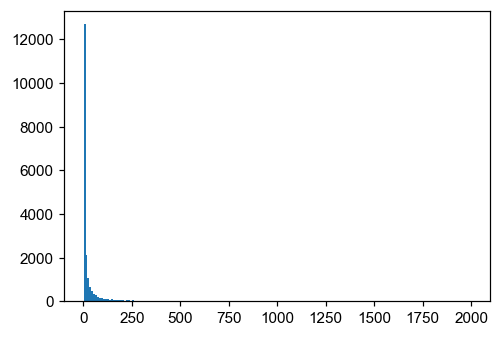

In [19]:
## don't need a function since the dict already exists
Xsamp = np.arange(1,n+1)/n
plt.hist([np.argmin(np.abs(dat[i,0]-Xsamp))+1 for i in range(len(dat))],bins=200);

In [1]:
# plt.hist(newdat[:,2],bins=100)
# plt.hist2d(np.log(newdat[:,0]),newdat[:,2][::-1],(25,25)); plt.colorbar()
# print(newdat[-5:,])
np.where(np.isinf(get_lp_alxl(gamma[-2], newdat[:,0], newdat[:,2], 100)))
# print(newdat[429,])
# get_lp_alxl(gamma[-2], newdat[:,0], newdat[:,2], 100)
# sXlred = np.around(newdat[:,0]*100).astype(int)
# np.sum((sXlred>0) & (sXlred<100))

NameError: name 'np' is not defined

In [15]:
import warnings
warnings.filterwarnings('error')
## just doing a lookup of sorts for the right probability
def get_lp_alxl(g, sXlred, alred, n=2000, cutoff=2):
    # Xsamp = np.arange(1,n)/n
    # sXlred = np.around(Xlred*n).astype(int) # rng.binomial(n, Xlred, len(Xlred))
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1)))
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        # if too many gens, then pass in a very low number (like -400.)
        # res[i] = np.log(p_xa_s[g][-int(alred[i]),np.argmin(np.abs(Xlred[i]-Xsamp))+1]) if (int(alred[i]<p_xa_s[g].shape[0])) else -400. 
        try:
            res[idx] = np.log(up_xa_s[g][-int(alred[i]),sXlred[i]]) if (int(alred[i])<up_xa_s[g].shape[0]) else np.median(np.log(up_xa_s[g][0,cutoff:(n-cutoff+1)]))
        except RuntimeWarning:
            print(g, sXlred[i], alred[i])
        # if np.isinf(res[idx]):
        #     print(i, Xlred[i], alred[i])

    return res

In [ ]:
## finding how many alleles have ages beyond computed values in the lookup matrix/table (like 4)
for ig, g in enumerate(gamma):
    alred = df1['al'].iloc[ig*1000:(ig+1)*1000]
    print(g, np.sum(alred>up_xa_s[g].shape[0]))

In [76]:
# trueg1 = -0.01
trueg2 = s[5]
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),:]
# newdf1 = newdf1.sample(frac=1)

newdat = newdf1.to_numpy()

In [ ]:
plt.scatter(get_lp_xl(g, newdat[:,5], cutoff=10), get_lp_xl2(g, newdat[:,5], cutoff=10), alpha=0.7, color='k', s=2.5); 
plt.axline((-5.75,1.75),slope=1.,color='grey',ls='--',linewidth=0.5);
plt.xlabel('p(X|γ) using moments framework'); plt.ylabel('using PRF approx')

In [77]:
# sin_onlyfreq = np.empty(len(gamma))
# sin_onlyage = np.empty(len(gamma))
num_sims = 16
num_samps = [1, 5, 10, 50, 100, 500]
info_onlyfreq, info_onlyage = np.zeros((len(num_samps),num_sims)), np.zeros((len(num_samps),num_sims))
# nboot = 10
# for i in range(nboot):
#     newdat = newdat[np.random.choice(len(newdat),1000,replace=True)]
    # for ig, g in enumerate(gamma):
        # sum log prob for each locus
        # sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,5], cutoff=2))
        # sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,5], newdat[:,2], cutoff=2))
        # mle = get_boot_ci(newdat,nboot=2)
    # print(gamma[np.argmax(sin_onlyfreq)], gamma[np.argmax(sin_onlyage)])

# for ig, g in enumerate(gamma):
#     sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,5], cutoff=2))
#     sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,5], newdat[:,2], cutoff=2))

# mle = get_boot_ci(newdat,nboot=20)
# mle.mean(axis=0), mle.std(axis=0)

for ins, ns in enumerate(num_samps):
    info_onlyfreq[ins,:], info_onlyage[ins,:] = get_info_content(newdat, num_samps=ns, num_sims=num_sims, cutoff=2)

In [19]:
def get_boot_ci(newdat, nsamps=1000, nboot=20, cutoff=2):
    mle = np.zeros((nboot,2))
    sin_onlyfreq, sin_onlyage = np.empty(len(gamma2)), np.empty(len(gamma2))
    for i in range(nboot):
        newnewdat = newdat[np.random.choice(len(newdat),nsamps,replace=True)]
        for ig, g in enumerate(gamma2):
            sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newnewdat[:,5], cutoff=cutoff))
            sin_onlyage[ig] = np.sum(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))
        
        mle[i,0] = gamma2[np.argmax(sin_onlyfreq)]
        mle[i,1] = gamma2[np.argmax(sin_onlyage)]

    return mle            

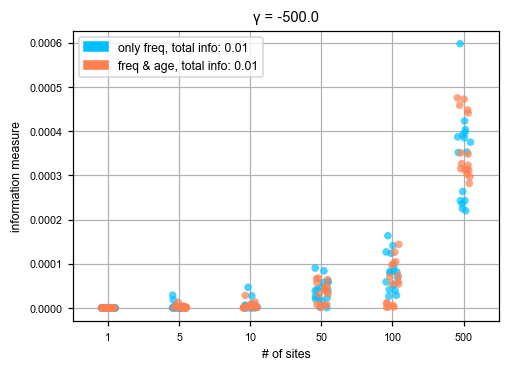

In [78]:
seaborn.stripplot(data=pd.DataFrame(info_onlyfreq.T,columns=num_samps), color='deepskyblue', alpha=0.7, label='only freq')
seaborn.stripplot(data=pd.DataFrame(info_onlyage.T,columns=num_samps), color='coral', alpha=0.7, label='freq & age')
# plt.semilogy(); 
plt.xlabel('# of sites'); plt.ylabel('information measure'); plt.grid(); plt.title('γ = {:.1f}'.format(trueg2))
plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='only freq, total info: {:.2f}'.format(np.sum(info_onlyfreq))), mpatches.Patch(color='coral', label='freq & age, total info: {:.2f}'.format(np.sum(info_onlyage)))])

In [52]:
def get_info_content(newdat, num_samps=800, num_sims=16, cutoff=10):
    ci_freq, ci_age = np.zeros(num_sims), np.zeros(num_sims)
    for n in range(num_sims):
        newnewdat = newdat[rng.choice(newdat.shape[0], num_samps, replace=False),:]
        sin_onlyfreq = [np.sum(get_lp_xl(g1, newnewdat[:,5], cutoff=cutoff)) for g1 in gamma2]
        sin_onlyage = [np.sum(get_lp_alxl(g1, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff)) for g1 in gamma2]

        ci_freq[n] = np.abs(get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma2)[0])
        ci_age[n] = np.abs(get_bfq(sin_onlyage-np.max(sin_onlyage), gamma2)[0])

    return [ci_freq, ci_age]

In [ ]:
def get_conf_int(loglik, thresh=2):
    mle = gamma[np.argmax(loglik)]

    if mle==np.min(gamma):
        lower_thresh = gamma[1]  
        return [(np.max(loglik)-thresh-loglik[np.argmax(loglik)+1])/(np.max(loglik) - loglik[np.argmax(loglik)+1])/(mle - lower_thresh)+lower_thresh, mle]
    elif mle==np.max(gamma):
        upper_thresh = gamma[-2] 
        return [mle, -thresh/(loglik[np.argmax(loglik)-1] - np.max(loglik))/(upper_thresh - mle)+mle]
    else:
        lower_thresh = gamma[np.argmax(loglik)+1] 
        upper_thresh = gamma[np.argmax(loglik)-1] 
        return [(np.max(loglik)-thresh-loglik[np.argmax(loglik)+1])*(mle - lower_thresh)/(np.max(loglik) - loglik[np.argmax(loglik)+1])+lower_thresh, -thresh*(upper_thresh - mle)/(loglik[np.argmax(loglik)-1] - np.max(loglik))+mle,]
        # return [(np.max(loglik)-thresh-loglik[np.argmax(loglik)+1])/(np.max(loglik) - loglik[np.argmax(loglik)+1])/(mle - lower_thresh)+lower_thresh, -thresh/(loglik[np.argmax(loglik)-1] - np.max(loglik))/(upper_thresh - mle)+mle]

In [ ]:
## run the same search on a denser grid
win_sin_onlyfreq = np.empty(interp_gamma.shape[1])
for ig, g in enumerate(interp_gamma[np.argmax(sin_onlyfreq),]):
    win_sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,5], cutoff=10))

win_sin_onlyage = np.empty(interp_gamma.shape[1])
for ig, g in enumerate(interp_gamma[np.argmax(sin_onlyage),]):
    win_sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,5], newdat[:,2], cutoff=10))

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
# lxlbfq = get_bfq_win(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((np.repeat(1.0,len(gamma)), gamma, gamma**2,))
# lxlalbfq = np.polynomial.polynomial.Polynomial.fit(gamma[7:10],(sin_onlyage-np.max(sin_onlyage))[7:10],deg=2).coef @ np.vstack((np.repeat(1.0,4), gamma[(np.argmax(sin_onlyage)-1):(np.argmax(sin_onlyage)+3)], gamma[(np.argmax(sin_onlyage)-1):(np.argmax(sin_onlyage)+3)]**2,))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
# lxlalbfq = get_bfq_win(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((np.repeat(1.0,len(gamma)), gamma, gamma**2,))

In [ ]:
plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
# plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');#interp_gamma
plt.axvline(-trueg2, color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
# plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');#interp_gamma[np.argmax(sin_onlyage)]
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

In [54]:
def get_bfq(loglik, gamma):
    ## does not work for some reason—wasted multiple hours on it...
    # return np.polynomial.polynomial.Polynomial.fit(-gamma[(ig-3):(ig+3)], loglik[(ig-3):(ig+3)], deg=2)
    igamma = gamma[(np.argmax(loglik)-1):(np.argmax(loglik)+2)] if np.argmax(loglik)>0 else gamma[0:3]
    loglik = loglik[(np.argmax(loglik)-1):(np.argmax(loglik)+2)] if np.argmax(loglik)>0 else loglik[0:3]

    rhs = np.array([np.dot(igamma**2,loglik), np.dot(igamma,loglik), np.sum(loglik)])
    lhs = np.array([[np.sum(igamma**4), np.sum(igamma**3), np.sum(igamma**2)],
    [np.sum(igamma**3), np.sum(igamma**2), np.sum(igamma)],
    [np.sum(igamma**2), np.sum(igamma), len(igamma)]])

    return np.linalg.solve(lhs, rhs) 

In [58]:
preds_sin_onlyfreq = np.zeros(len(s))
ci_sin_onlyfreq = np.zeros((len(s),2))

for ig, g in enumerate(s):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    # sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=5)) for g1 in gamma]
    # preds_sin_onlyfreq[ig] = gamma[np.argmax(sin_onlyfreq)]
    # ci_sin_onlyfreq[ig] = 1/np.abs(get_bfq(sin_onlyfreq - np.argmax(sin_onlyfreq), gamma)[0]) # get_conf_int(sin_onlyfreq)
    info_onlyfreq[ig,:], info_onlyage[ig,:] = get_info_content(newdat, num_samps=1000, num_sims=16)

In [ ]:
# preds_sin_agefreq = np.zeros(len(gamma))
# for ig, g in enumerate(gamma):
#     newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
#     newdat = newdf1.to_numpy()
#     sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2]) + get_lp_xl(g1, newdat[:,5])) for g1 in gamma]
#     # sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100)) for g1 in gamma]
#     preds_sin_agefreq[ig] = gamma[np.nanargmax(sin_agefreq)]

In [ ]:
preds_sin_onlyage = np.zeros(len(gamma))
ci_sin_onlyage = np.zeros((len(gamma),2))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    # newdat = newdf1.loc[np.logical_and(newdf1['al']>1, newdf1['al']<60),:].to_numpy()
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=5)) for g1 in gamma]
    preds_sin_onlyage[ig] = gamma[np.argmax(sin_onlyage)]
    ci_sin_onlyage[ig] = 1/np.abs(get_bfq(sin_onlyage-np.argmax(sin_onlyage), gamma)[0]) # get_conf_int(sin_onlyage)

In [33]:
## get bootstrap std estimates but mle only calculated once
preds_sin_onlyfreq, preds_sin_onlyage = np.zeros(len(gamma)), np.zeros(len(gamma))
ci_sin_onlyfreq, ci_sin_onlyage = np.zeros((len(gamma),)), np.zeros((len(gamma),))

for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2]
    preds_sin_onlyfreq[ig] = gamma2[np.argmax(sin_onlyfreq)]
    preds_sin_onlyage[ig] = gamma2[np.argmax(sin_onlyage)]
    mle = get_boot_ci(newdat, nsamps=len(newdat), nboot=50)
    ci_sin_onlyfreq[ig,], ci_sin_onlyage[ig,] = mle.std(axis=0) #np.percentile(mle[:,0],[97.5,2.5]), np.percentile(mle[:,1],[97.5,2.5]) 

array([-0.316, -0.401, -0.509, -0.646, -0.820, -1.040, -1.320, -1.675,
       -2.126, -2.698, -3.424, -4.344, -5.513, -6.996, -8.877, -11.265,
       -14.295, -18.139, -23.018, -29.209, -37.065, -47.034, -59.685,
       -75.737, -96.108, -121.957, -154.759, -196.383, -249.202, -316.228,
       -400.000, -500.000])

In [46]:
## get bootstrap std estimates but mle only calculated once
preds_sin_onlyfreq, preds_sin_onlyage = np.zeros(len(s)), np.zeros(len(s))
ci_sin_onlyfreq, ci_sin_onlyage = np.zeros((len(s),)), np.zeros((len(s),))

for ig, g in enumerate(s):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2]
    preds_sin_onlyfreq[ig] = gamma2[np.argmax(sin_onlyfreq)]
    preds_sin_onlyage[ig] = gamma2[np.argmax(sin_onlyage)]
    mle = get_boot_ci(newdat, nsamps=len(newdat), nboot=50)
    ci_sin_onlyfreq[ig,], ci_sin_onlyage[ig,] = mle.std(axis=0) #np.percentile(mle[:,0],[97.5,2.5]), np.percentile(mle[:,1],[97.5,2.5]) 

In [456]:
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==s[4])),:]
# newdat = newdf1.to_numpy()
# sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]
# sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2]
# gamma2[np.argmax(sin_onlyfreq)], gamma2[np.argmax(sin_onlyage)]
# get_boot_ci(newdat, nsamps=len(newdat), nboot=50)

array([[-96.108, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-75.737, -75.737],
       [-75.737, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-75.737, -96.108],
       [-75.737, -96.108],
       [-75.737, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-96.108, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-75.737, -75.737],
       [-75.737, -96.108],
       [-75.737, -75.737],
       [-75.737, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-96.108, -96.108],
       [-75.737, -96.108],
       [-75.737, -96.108],
 

In [303]:
## basically, do fitdadi inference for each selection coefficient
## cannot do point selection coefficient inference
import dadi
df = pd.read_csv("PReFerSims/outfiles/ConstantSize2.0.1.full_out.txt", sep="\t", header=None).sample(n=1000)
fs = dadi.Spectrum(np.histogram(fdf.iloc[:, 1] * 2000, bins=2001)[0])
def one_epoch_sel(params, ns, pts):
    nu, T, gamma = params
    xx = dadi.Numerics.default_grid(pts)
    phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
    phi = dadi.Integration.one_pop(phi, xx, T, nu, gamma=gamma)
    fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
    return fs
pts_l = [600, 800, 1000]
spectra = Selection.spectra(
    [1, 2],
    np.array([2000]),
    one_epoch_sel,
    pts_l=pts_l,
    int_bounds=[0.1, 100],
    Npts=20,
    echo=True,
)
sel_params = [0.1, 200.0]
lower_bound = [1e-3, 1e-2]
upper_bound = [1, 100.0]
p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound, upper_bound=upper_bound)
popt = Selection.optimize_log(
    p0,
    fs,
    spectra.integrate,
    Selection.normal_dist,
    300,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    verbose=len(sel_params),
    maxiter=30,
)
spectra.Integrate(popt[1], Selection.normal_dist, 300)
spectra.integrate([1.,4.], Selection.normal_dist, 300)

array([0.000, 0.000, 3.251, 4.315, 0.000, 38.109])

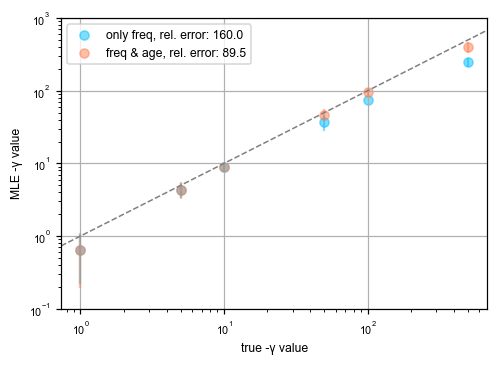

In [47]:
plt.scatter(-s, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, rel. error: {:.1f}'.format(np.sum(np.abs(s-preds_sin_onlyfreq)*100/-s)),)#s=truenumloci*50/1000)
plt.errorbar(-s, -preds_sin_onlyfreq, yerr=1.96*ci_sin_onlyfreq[:], color='deepskyblue', alpha=0.5, ls='none')
plt.scatter(-s, -preds_sin_onlyage, color='coral', alpha=0.5, label='freq & age, rel. error: {:.1f}'.format(np.sum(np.abs(s-preds_sin_onlyage)*100/-s)),)#s=truenumloci*50/1000)
plt.errorbar(-s, -preds_sin_onlyage, yerr=1.96*ci_sin_onlyage[:], color='coral', alpha=0.5, ls='none')
plt.xlabel('true -γ value'); plt.ylabel('MLE -γ value'); plt.legend(); plt.loglog()
plt.axline((1,1),(100,100),color='grey',ls='--', linewidth=1.); plt.ylim((0.1,1000)); plt.grid()

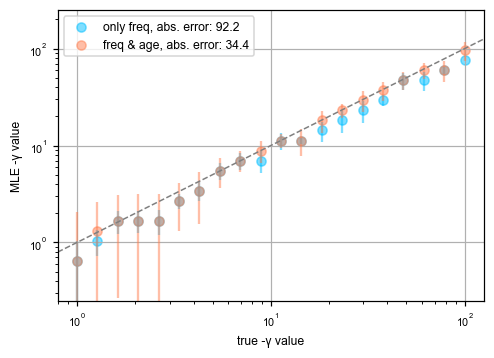

In [34]:
plt.scatter(-gamma, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_onlyfreq))),)#s=truenumloci*50/1000)
# plt.vlines(-gamma, -ci_sin_onlyfreq[:,0], -ci_sin_onlyfreq[:,1], color='deepskyblue', alpha=0.5)
plt.errorbar(-gamma, -preds_sin_onlyfreq, yerr=1.96*ci_sin_onlyfreq[:], color='deepskyblue', alpha=0.5, ls='none')
# plt.errorbar(-gamma, -preds_sin_onlyfreq, yerr=-ci_sin_onlyfreq.T, color='deepskyblue', alpha=0.5, ls='none')
plt.scatter(-gamma, -preds_sin_onlyage, color='coral', alpha=0.5, label='freq & age, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_onlyage))),)#s=truenumloci*50/1000)
# plt.vlines(-gamma, -ci_sin_onlyage[:,0], -ci_sin_onlyage[:,1], color='coral', alpha=0.5)
plt.errorbar(-gamma, -preds_sin_onlyage, yerr=1.96*ci_sin_onlyage[:]+1, color='coral', alpha=0.5, ls='none')
# plt.errorbar(-gamma, -preds_sin_onlyage, yerr=-ci_sin_onlyage.T, color='coral', alpha=0.5, ls='none'); plt.yscale('log')
# plt.scatter(-gamma, -preds_sin_agefreq, color='darkgreen', alpha=0.5, label='age & freq, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_agefreq))))
plt.xlabel('true -γ value'); plt.ylabel('MLE -γ value'); plt.legend(); plt.loglog()
plt.axline((1,1),(100,100),color='grey',ls='--', linewidth=1.); plt.ylim((0.1,250)); plt.grid()

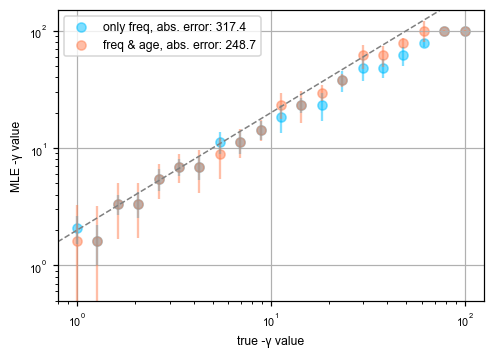

In [170]:
plt.scatter(-gamma, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, abs. error: {:.1f}'.format(np.sum(np.abs(2.*gamma-preds_sin_onlyfreq))),)#s=truenumloci*50/1000)
# plt.vlines(-gamma, -ci_sin_onlyfreq[:,0], -ci_sin_onlyfreq[:,1], color='deepskyblue', alpha=0.5)
plt.errorbar(-gamma, -preds_sin_onlyfreq, yerr=1.96*ci_sin_onlyfreq[:], color='deepskyblue', alpha=0.5, ls='none')
# plt.errorbar(-gamma, -preds_sin_onlyfreq, yerr=-ci_sin_onlyfreq.T, color='deepskyblue', alpha=0.5, ls='none')
plt.scatter(-gamma, -preds_sin_onlyage, color='coral', alpha=0.5, label='freq & age, abs. error: {:.1f}'.format(np.sum(np.abs(2.*gamma-preds_sin_onlyage))),)#s=truenumloci*50/1000)
# plt.vlines(-gamma, -ci_sin_onlyage[:,0], -ci_sin_onlyage[:,1], color='coral', alpha=0.5)
plt.errorbar(-gamma, -preds_sin_onlyage, yerr=1.96*ci_sin_onlyage[:]+1, color='coral', alpha=0.5, ls='none')
# plt.errorbar(-gamma, -preds_sin_onlyage, yerr=-ci_sin_onlyage.T, color='coral', alpha=0.5, ls='none'); plt.yscale('log')
# plt.scatter(-gamma, -preds_sin_agefreq, color='darkgreen', alpha=0.5, label='age & freq, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_agefreq))))
plt.xlabel('true -γ value'); plt.ylabel('MLE -γ value'); plt.legend(); plt.loglog()
plt.axline((1,2),(100,200),color='grey',ls='--', linewidth=1.); plt.ylim((0.5,150)); plt.grid()

In [20]:
# dft = pd.read_csv("../traindata/trip-2022-04-05.csv")
# dft['gamma'] = dft['gamma'].round(decimals=2)
# gamma

,Xl,s,al,id,empty,sXl
0,0.0005,-1.0,329,14953567.0,,1
1,0.049,-1.0,1047,14846160.0,,98
2,0.022,-1.0,2069,14693514.0,,44
3,0.0095,-1.0,729,14893581.0,,19
4,0.0005,-1.0,101,14988331.0,,1
...,...,...,...,...,...,...
8995,0.0005,-500.0,1,74986788.0,,1
8996,0.0005,-500.0,19,74973020.0,,1
8997,0.003,-500.0,117,74899350.0,,6
8998,0.0005,-500.0,21,74971365.0,,1


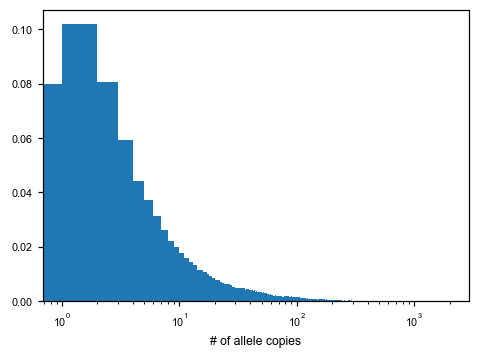

In [55]:
## comparing empirical distribution from data of frequency values with likelihood from moments framework
# basically take samples from binomial for each rep and then store the values in a vector that keeps getting updated...
ir = np.empty((100,1500),dtype=int)
for n in range(100): #nreps
    ir[n,:] = rng.binomial(n=2000, p=df1[df1['s']==-10.]['Xl'])
counts, bins, _ = plt.hist(np.ravel(ir),bins=2000,range=(0,2000),density=True); plt.semilogx(); plt.xlabel('# of allele copies')
counts[cutoff:(2000-cutoff+1)] = counts[cutoff:(2000-cutoff+1)]/np.sum(counts[cutoff:(2000-cutoff+1)])
counts[0:cutoff] = counts[-cutoff:] = np.repeat(0,cutoff)

In [53]:
## numerical integration of likelihood to get analytical expression (from eq 2 in Bustamante et al 2001)
def Fanal(gg, i, n):
    with np.errstate(divide='ignore'):
        return [(1-np.exp(-2*gg*(1-x)))*2/((1-np.exp(-2*gg))*x*(1-x)) * sp.stats.binom.pmf(i,n,x) for x in np.logspace(-8,-0.01,99)]

analexp = [sp.integrate.trapezoid(Fanal(-11.625/2,i,2000),np.logspace(-8,-0.01,99)) for i in range(2000)]
analexp[cutoff:(2000-cutoff+1)] = analexp[cutoff:(2000-cutoff+1)]/np.sum(analexp[cutoff:(2000-cutoff+1)])
analexp[0:cutoff] = analexp[-cutoff:] = np.repeat(0,cutoff)

In [737]:
# np.corrcoef([sp.integrate.trapezoid(Fanal(gamma[19],i,2000),np.linspace(1e-6,1-1e-6,200)) for i in range(20)], [sp.integrate.trapezoid(Fanal(gamma[0],i,2000),np.linspace(1e-6,1-1e-6,200)) for i in range(20)])
# Fanal(gamma[19],10,2000), Fanal(gamma[0],10,2000) 
# np.linspace(1e-6,1-1e-6,20)

In [23]:
# plt.scatter(p_xa_s[gamma[15]],p_xa_s[gamma[17]]); plt.loglog(); plt.axline((0.1,0.1),(0,0))
# np.allclose(p_xa_s[gamma[19]],p_xa_s[gamma[16]])
gamma2

array([-0.316, -0.401, -0.509, -0.646, -0.820, -1.040, -1.320, -1.675,
       -2.126, -2.698, -3.424, -4.344, -5.513, -6.996, -8.877, -11.265,
       -14.295, -18.139, -23.018, -29.209, -37.065, -47.034, -59.685,
       -75.737, -96.108, -121.957, -154.759, -196.383, -249.202, -316.228])

Text(0.5, 0, '# of allele copies')

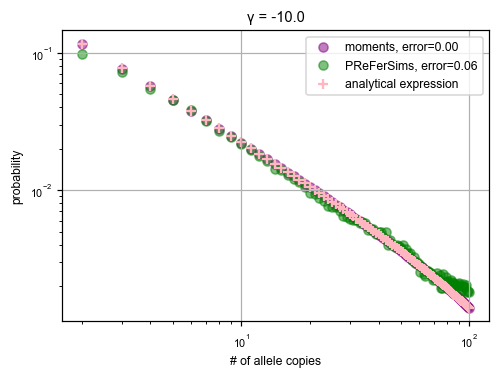

In [56]:
plt.scatter(np.arange(2,100+1),p_xa_s[gamma2[15]][2:101],color='purple',label='moments, error={:.2f}'.format(np.sum(np.abs(p_xa_s[gamma2[15]][2:101]-analexp[2:101]))),alpha=0.5);
# plt.scatter(np.arange(2,100+1),testp_xa_s[2:101],color='grey',label='moments2, error={:.2f}'.format(np.sum(np.abs(testp_xa_s[2:101]-analexp[2:101]))),alpha=0.5);
plt.scatter(np.arange(2,100+1),counts[2:101],color='green',label='PReFerSims, error={:.2f}'.format(np.sum(np.abs(counts[2:101]-analexp[2:101]))),alpha=0.5); 
plt.scatter(np.arange(2,100+1),analexp[2:101],color='lightpink',marker='+',label='analytical expression');  plt.grid(); plt.loglog()
plt.ylabel('probability'); plt.title('γ = {}'.format(-10.)); plt.legend(); plt.xlabel('# of allele copies')

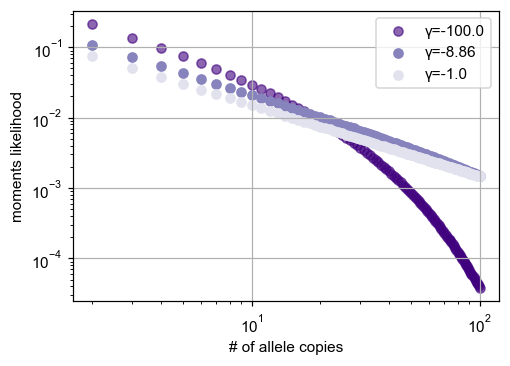

In [29]:
## plotting different SFS from moments on the same plot
plt.scatter(np.arange(2,100+1),p_xa_s[gamma[0]][2:101],color=cm.get_cmap('Purples',6)(5),alpha=0.6,label='γ={}'.format(gamma[0])); 
plt.scatter(np.arange(2,100+1),p_xa_s[gamma[10]][2:101],color=cm.get_cmap('Purples',6)(3),label='γ={}'.format(gamma[10])); 
plt.scatter(np.arange(2,100+1),p_xa_s[gamma[-1]][2:101],color=cm.get_cmap('Purples',6)(1),label='γ={}'.format(gamma[-1])); 
plt.xlabel('# of allele copies'); plt.ylabel('moments likelihood'); plt.legend(); plt.loglog(); plt.grid()


In [734]:
preds_sin_onlyfreq, ci_sin_onlyfreq, preds_sin_onlyage, ci_sin_onlyage

(array([-100.000, -100.000, -78.480, -78.480, -61.580, -48.330, -37.930,
        -29.760, -23.360, -18.330, -14.380, -14.380, -8.860, -8.860,
        -6.950, -4.280, -3.360, -2.640, -2.640, -1.270]),
 array([0.000, 0.000, 10.760, 3.312, 5.949, 3.813, 2.426, 2.216, 2.607,
        2.464, 0.774, 0.729, 1.215, 0.598, 0.636, 0.467, 0.325, 0.387,
        0.305, 0.247]),
 array([-100.000, -100.000, -78.480, -61.580, -48.330, -37.930, -29.760,
        -23.360, -18.330, -18.330, -11.290, -11.290, -6.950, -6.950,
        -5.460, -4.280, -3.360, -2.640, -2.070, -1.270]),
 array([0.000, 0.000, 4.217, 4.312, 4.572, 2.474, 3.779, 3.197, 2.282,
        1.587, 1.161, 0.657, 0.927, 0.848, 0.404, 0.398, 0.303, 0.369,
        0.287, 0.190]))

In [736]:
# plt.figure(dpi=150)
import matplotlib.patches as mpatches
seaborn.stripplot(data=pd.DataFrame(info_onlyfreq.T,columns=-gamma[::-1]), color='deepskyblue', alpha=0.7, label='only freq',s=4)
seaborn.stripplot(data=pd.DataFrame(info_onlyage.T,columns=-gamma[::-1]), color='coral', alpha=0.7, label='freq & age',s=4)
plt.semilogy(); plt.xlabel('gamma'); plt.ylabel('information measure'); plt.grid(); 
plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='only freq, total info: {:.2f}'.format(np.sum(info_onlyfreq))), mpatches.Patch(color='coral', label='freq & age, total info: {:.2f}'.format(np.sum(info_onlyage)))])

NameError: name 'info_onlyfreq' is not defined

In [ ]:
## plotting error rates across selection coefficients
plt.plot(-gamma, np.abs(gamma-preds_sin_onlyfreq), color='deepskyblue', alpha=0.8, label='only freq'.format(np.sum(np.abs(gamma-preds_sin_onlyfreq))), ls='--')
plt.plot(-gamma, np.abs(gamma-preds_sin_onlyage), color='coral', label='freq & age', alpha=0.8, ls='--')
plt.legend(); plt.semilogx(); plt.xlabel('-γ'); plt.ylabel('absolute error'); plt.show()

plt.plot(-gamma, -np.abs(gamma-preds_sin_onlyfreq)*100/gamma, color='deepskyblue', alpha=0.8, label='only freq, total: {:.2f}'.format(np.sum(-np.abs(gamma-preds_sin_onlyfreq)*100/gamma)), ls='--')
plt.plot(-gamma, -np.abs(gamma-preds_sin_onlyage)*100/gamma, color='coral', label='freq & age, total: {:.2f}'.format(np.sum(-np.abs(gamma-preds_sin_onlyage)*100/gamma)), alpha=0.8, ls='--')
plt.legend(); plt.semilogx(); plt.xlabel('-γ'); plt.ylabel('relative error'); plt.show()

In [111]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = s[4]
trueg2 = s[5]
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),:])
# newdf1 = newdf1.sample(frac=1)

# only keeping alleles with ages > 1 (cos NN & PRF approx finds really high prob for these alleles to have small gamma...)
newdat = newdf1.to_numpy()

In [113]:
## assuming two selection coefficients and only freq info (split 50/50)
dub_onlyfreq = np.zeros((len(gamma2),len(gamma2))) # need a 2d search
for ig1, g1 in enumerate(gamma2):
    for ig2, g2 in enumerate(gamma2[0:(ig1+1)]):
        dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,5])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,5]))))

mask = np.full(dub_onlyfreq.shape,False)
mask[np.triu_indices_from(dub_onlyfreq,k=1)] = True

array([-48.330, -48.330])

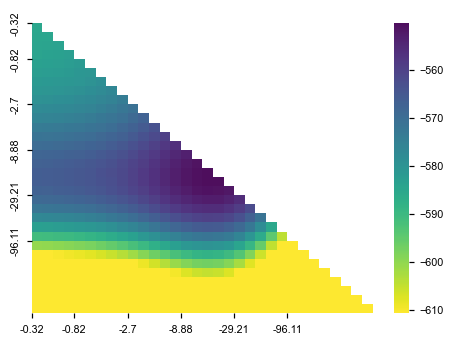

In [121]:
seaborn.heatmap(dub_onlyfreq,alpha=0.95,cmap='viridis_r',mask=mask,vmax=np.max(dub_onlyfreq[~mask])-5,vmin=np.max(dub_onlyfreq[~mask]))
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

In [116]:
## assuming two selection coefficients and only age info (split 50/50)
dub_onlyage = np.zeros((len(gamma2),len(gamma2))) # need a 2d search
for ig1, g1 in enumerate(gamma2):
    for ig2, g2 in enumerate(gamma2[0:(ig1+1)]):
        dub_onlyage[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,5], newdat[:,2])) + 
        0.5*np.exp(get_lp_alxl(g2, newdat[:,5], newdat[:,2]))))

IndexError: index 25 is out of bounds for axis 0 with size 20

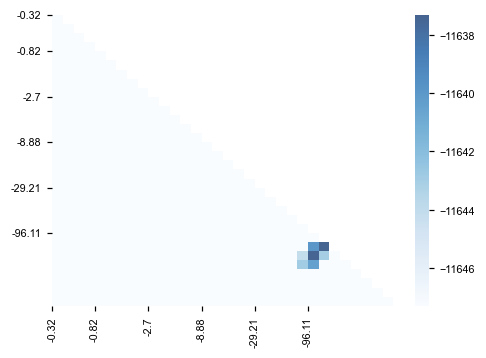

In [118]:
seaborn.heatmap(dub_onlyage,alpha=0.75,xticklabels=gamma,yticklabels=gamma,cmap='Blues',mask=mask,vmin=np.max(dub_onlyage[~mask])-10,vmax=np.max(dub_onlyage[~mask]))
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyfreq.shape))

In [119]:
np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape)
np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape)
# print(np.max(dub_onlyfreq[~mask]))
# print(np.max(dub_onlyage[~mask]))
# dub_onlyfreq[24,]
# dub_onlyage[21,]

(16, 16)

### What if there was only one $\gamma$ in the data? 

In [ ]:
samepredsonlyfreq = np.zeros((len(gamma),4))
samepredsagefreq = np.zeros((len(gamma),4))
for itg, trueg in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg)),:]

    newdat = newdf1.to_numpy()
    
    sin_onlyfreq = np.zeros(len(gamma))
    sin_agefreq = np.zeros(len(gamma))
    
    dub_onlyfreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
    dub_agefreq = np.zeros((len(gamma),len(gamma))) # need a 2d search

    for ig1, g1 in enumerate(gamma):
        sin_onlyfreq[ig1] = np.sum(get_lp_xl(g1, newdat[:,5]))
        # sin_agefreq[ig1] = np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0]))
        sin_agefreq[ig1] = np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2]))

        for ig2, g2 in enumerate(gamma[0:(ig1+1)]):        
            dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,5])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,5]))))
    
            # dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g2, newdat[:,0]))))
            
            dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,5], newdat[:,2])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,5], newdat[:,2]))))

    estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

    estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
    estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

    lambfreq = 2.*(np.max(dub_onlyfreq[~mask]) - np.max(sin_onlyfreq))

    samepredsonlyfreq[itg,2] = estgonlyfreq

    samepredsonlyfreq[itg,:2] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

    if(chi2.sf(lambfreq, 1)<0.05):
        samepredsonlyfreq[itg,3] = True
    else:
        samepredsonlyfreq[itg,3] = False

    estgagefreq = gamma[np.nanargmax(sin_agefreq)]        

    estg1agefreq = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))[0]
    estg2agefreq = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))[1]

    lambagefreq = 2.*(np.nanmax(dub_agefreq[~mask]) - np.nanmax(sin_agefreq))

    samepredsagefreq[itg,2] = estgagefreq

    samepredsagefreq[itg,:2] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))

    if(chi2.sf(lambagefreq, 1)<0.05):
        samepredsagefreq[itg,3] = True
    else:
        samepredsagefreq[itg,3] = False

In [ ]:
# np.max(dub_onlyfreq) - np.max(sin_onlyfreq)
samepredsagefreq

In [ ]:
## plotting the above results
plt.scatter(-gamma, -samepredsonlyfreq[:,0], color='deepskyblue', marker='+', alpha=0.5)
plt.scatter(-gamma, -samepredsonlyfreq[:,1], color='deepskyblue', marker='+', label='estimates using only freq', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,0], color='coral', marker='*', label='estimates using freq & age', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,1], color='coral', marker='*', alpha=0.5)
plt.xlabel('true -γ value'); plt.ylabel('predicted -γ value(s)'); plt.loglog()
plt.axline((0.01,0.01),(100,100),color='grey',ls='--'); plt.legend()

### Template code to compute difference in $\gamma$ given set of data

Here, I will run the mechanism to compute the probability of a significant difference in selection coefficients is detected given a set of large data i.e., 2000 data points and I will resample 25 times to obtain smaller datasets of 500. 

In [106]:
# num_sims is number of reps to run to calculate prob
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_freq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05, cutoff=cutoff):
    prob = 0.
    sin_onlyfreq = np.empty(len(gamma))
    dub_onlyfreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newnewdat[:,5], cutoff=cutoff))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyfreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g, newnewdat[:,5], cutoff=cutoff)) + 0.5*np.exp(get_lp_xl(g2, newnewdat[:,5], cutoff=cutoff))))


        estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

        # estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
        # estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]
        estg1onlyfreq, estg2onlyfreq = np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

        lambfreq = 2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])

        if(chi2.sf(lambfreq, 1)<thresh):
            prob += 1.

    return [prob/num_sims, estgonlyfreq, np.array([estg1onlyfreq, estg2onlyfreq])]

In [ ]:
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.

    sin_agefreq = np.empty(len(gamma))
    
    dub_agefreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_agefreq[ig] = np.sum(get_lp_alxl(g, newnewdat[:,0], newnewdat[:,2], n=100) + get_lp_xl(g, newnewdat[:,0]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_agefreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2]) + get_lp_xl(g, newnewdat[:,5])) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2]) + get_lp_xl(g2, newnewdat[:,5]))))

        estgagefreq = gamma[np.nanargmax(sin_agefreq)]        

        estg1agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[0]]
        estg2agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[1]]

        lambagefreq = 2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])

        if(chi2.sf(lambagefreq, 1)<thresh):
            prob += 1.

    return prob/num_sims

In [24]:
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_age(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05, cutoff=cutoff):
    prob = 0.

    sin_onlyage = np.empty(len(gamma))
    
    dub_onlyage = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyage[ig] = np.sum(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyage[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff)) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))))

        estgonlyage = gamma[np.argmax(sin_onlyage)]        

        # estg1onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[0]]
        # estg2onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[1]]
        estg1onlyage, estg2onlyage = np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape))

        lambonlyage = 2.*(dub_onlyage[gamma==estg1onlyage,gamma==estg2onlyage] - sin_onlyage[gamma==estgonlyage])

        if(chi2.sf(lambonlyage, 1)<thresh):
            prob += 1.

    return [prob/num_sims, estgonlyage, np.array([estg1onlyage, estg2onlyage])]

In [25]:
diffgamma = np.reshape(list(it.combinations(gamma[0::2], 2)), (-1,2)) # np.reshape([(-1., x) for x in gamma[:-1][::2]], (-1,2)) #
diffprobs = np.zeros((len(diffgamma),2))
sinpreds = np.zeros((len(diffgamma),2))
dubpreds = np.zeros((len(diffgamma),4))
for ig, g in enumerate(diffgamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g[0])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==g[1])),:])
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    diffprobs[ig,0], sinpreds[ig,0], dubpreds[ig,:2] = resample_calculateprob_freq(newdat, gamma2, num_sims=20, num_samps=1500, cutoff=2)
    diffprobs[ig,1], sinpreds[ig,1], dubpreds[ig,-2:] = resample_calculateprob_age(newdat, gamma2, num_sims=20, num_samps=1500, cutoff=2)

In [130]:
# plt.hist(newdf1['al'].iloc[:1500],np.logspace(0,3)); plt.hist(newdf1['al'].iloc[1500:],np.logspace(0,3),alpha=0.5)


KeyError: -100.0

In [110]:
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==s[5])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==s[4])),:])
# newdat = newdf1.to_numpy()
# print(resample_calculateprob_freq(newdat, gamma2, num_sims=16, num_samps=1200, cutoff=2))
# print(resample_calculateprob_age(newdat, gamma2, num_sims=16, num_samps=1200, cutoff=2))
newnewdat = newdat[np.random.choice(newdat.shape[0], 1200, replace=False),:]
for ig, g in enumerate(gamma2):
    # sum log prob for each locus
    sin_onlyage[ig] = np.sum(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))
    for ig2, g2 in enumerate(gamma2[0:(ig+1)]):
        dub_onlyage[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff)) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))))

print(gamma[np.argmax(sin_onlyage)])
print(np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape)))

NameError: name 'dub_onlyage' is not defined

In [459]:
diffgamma = np.reshape(list(it.combinations(s, 2)), (-1,2)) # np.reshape([(-1., x) for x in gamma[:-1][::2]], (-1,2)) #
diffprobs = np.zeros((len(diffgamma),2))
sinpreds = np.zeros((len(diffgamma),2))
dubpreds = np.zeros((len(diffgamma),4))
for ig, g in enumerate(diffgamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g[0])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==g[1])),:])
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    diffprobs[ig,0], sinpreds[ig,0], dubpreds[ig,:2] = resample_calculateprob_freq(newdat, gamma2, num_sims=20, num_samps=1500, cutoff=2)
    diffprobs[ig,1], sinpreds[ig,1], dubpreds[ig,-2:] = resample_calculateprob_age(newdat, gamma2, num_sims=20, num_samps=1500, cutoff=2)

In [26]:
## alternative plotting mechanism to highlight the power in discriminating between gamma values
powermat_freq = np.empty((len(np.unique(diffgamma)),len(np.unique(diffgamma))))
powermat_age = np.empty((len(np.unique(diffgamma)),len(np.unique(diffgamma))))

mask_pow = np.full(powermat_freq.shape,False)
mask_pow[np.tril_indices_from(powermat_freq,k=-1)] = True

for ig, g in enumerate(diffgamma[:,]):
    powermat_freq[np.argmax(g[0]==np.unique(diffgamma)), np.argmax(g[1]==np.unique(diffgamma))] = diffprobs[ig, 0]
    powermat_age[np.argmax(g[0]==np.unique(diffgamma)), np.argmax(g[1]==np.unique(diffgamma))] = diffprobs[ig, 1]

In [27]:
for ig, g in enumerate(np.unique(diffgamma)):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    powermat_freq[ig,ig], _, _ = resample_calculateprob_freq(newdat, gamma2, num_sims=16, num_samps=1500, cutoff=2)
    powermat_age[ig,ig], _, _ = resample_calculateprob_age(newdat, gamma2, num_sims=16, num_samps=1500, cutoff=2)

In [ ]:
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==np.unique(diffgamma)[2])),:]
newdat = newdf1.to_numpy()
print(resample_calculateprob_age(newdat, gamma, num_samps=800, cutoff=10))
resample_calculateprob_freq(newdat, gamma, num_samps=800, cutoff=10)

In [ ]:
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==gamma[6])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==gamma[-1])),:])
# newdat = newdf1.to_numpy()
# print(resample_calculateprob_freq(newdat, gamma, num_sims=10, num_samps=1000, cutoff=50))
# print(resample_calculateprob_age(newdat, gamma, num_sims=10, num_samps=1000))

In [ ]:
plt.scatter([-np.mean(g) for g in diffgamma], -sinpreds[:,0], color='deepskyblue', marker='+', label='only freq')
plt.scatter([-np.mean(g) for g in diffgamma], -sinpreds[:,1], color='coral', marker='*', label='freq & age',)
plt.xlabel('mean of true γ'); plt.ylabel('predicted γ'); plt.loglog(); plt.legend() 
plt.axline((1,1),(100,100),color='grey',ls='--')

In [ ]:
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], color='deepskyblue', alpha=0.7, label='only freq') #s=truenumlocifreq[:-1]/(truenumlocifreq[:-1]+truenumlocifreq[-1])*70.)
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], color='coral', alpha=0.7, label='freq & age')
ginterp = np.logspace(0,4.5,base=np.exp(1),num=25)
fit = sp.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='deepskyblue', alpha=0.7)
fit = sp.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='coral', alpha=0.7)
plt.ylim((-0.1,1.1)); plt.xscale('log'); plt.xlabel('log(|γ1-γ2|)'); plt.ylabel('prob of choosing complex model'); plt.legend()

In [437]:
powermat_freq

array([[0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.100, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.400, 0.600, 0.050, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.900, 0.950, 0.600, 0.050, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [1.000, 0.900, 0.900, 0.400, 0.250, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.950, 0.950, 1.000, 0.750, 0.750, 0.150, 0.000, 0.000, 0.000,
        0.000],
       [1.000, 1.000, 0.950, 0.800, 0.900, 0.300, 0.100, 0.000, 0.000,
        0.000]])

<AxesSubplot:title={'center':'freq & age'}>

<Figure size 1000x700 with 0 Axes>

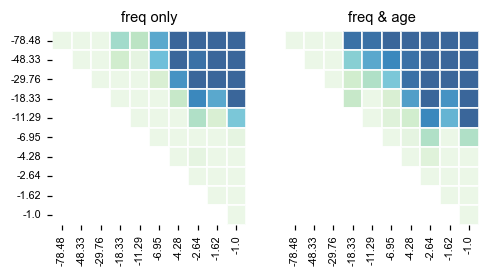

In [28]:
# np.hstack((diffgamma, dubpreds))
# np.argmax(diffgamma[0][1]==np.unique(diffgamma))
plt.figure(dpi=200)
fig, (ax1, ax2) = plt.subplots(1,2)
seaborn.heatmap(powermat_freq.T, mask=mask_pow, xticklabels=np.unique(diffgamma), yticklabels=np.unique(diffgamma), cmap='GnBu', ax=ax1, cbar=False, linewidths=0.05, square=True,alpha=0.8,vmin=-0.1);
ax1.set_title('freq only'); ax2.set_title('freq & age'); 
seaborn.heatmap(powermat_age.T, mask=mask_pow, xticklabels=np.unique(diffgamma), yticklabels=[], cmap='GnBu', square=True, ax=ax2, linewidths=0.05, vmin=-0.1, cbar=False, cbar_kws={'label': 'prob of choosing complex model'},alpha=0.8)

In [ ]:
truenumloci = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    sXlred = newdf1['sXl']
    truenumloci[ig] = np.sum((sXlred>10) & (sXlred<n-10+1))

truenumlocifreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    truenumlocifreq[ig] = newdf1.to_numpy().shape[0]

truenumloci

### Automating workflow for simulating point DFE from PReFerSim (instead of using the R approach from before)

Here, I will write a python function to run the program with appropriate parameters and read the input into a dataframe after.

In [17]:
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
## creating a small set of gamma for simulating data (testing framework) 
## gamma = 4Ns potentially (yes, if it has to coincide with the moments framework)
# gamma = -np.round(np.logspace(0,2,20),2) 
s = -np.array([1.,5.,10.,50.,100.,500.])
# for ig, g in enumerate(s):
#     with open('simfiles/ParameterFilesConstant.txt',"r") as file:
#         data = file.readlines()

#     data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-0.25*g/10000)
#     data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

#     with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
#         file.writelines(data)
        
#     os.system("GSL_RNG_SEED=1004 GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 1")

In [18]:
## reading in the data and storing in a data frame
nsites = 1500
df1 = pd.DataFrame(index=range(nsites*len(s)),columns=['','Xl','s','al','id'])
for ig, g in enumerate(s):
    # if(g==-100.):
    #     df1.iloc[(ig*nsites):(ig+1)*nsites] = pd.read_csv('outfiles/ConstantSize50.0.1.full_out.txt'.format(-g),sep='\t',header=None).sample(n=nsites)
    # elif(g==-1.):
    #     df1.iloc[(ig*nsites):(ig+1)*nsites] = pd.read_csv('outfiles/ConstantSize2.0.1.full_out.txt'.format(-g),sep='\t',header=None).sample(n=nsites)
    # else:
    df1.iloc[(ig*nsites):(ig+1)*nsites] = pd.read_csv('outfiles/ConstantSize{}.1.full_out.txt'.format(-g),sep='\t',header=None).sample(n=nsites)
    df1['s'].iloc[(ig*nsites):(ig+1)*nsites] = np.repeat(g,nsites)
df1['empty'] = ''
df1['sXl'] = (df1['Xl']*2000).astype('int')
df1['al'] = 100000+1 - df1['al']
df1['al'] = df1['al'].astype('int')
df1 = df1.iloc[:,1:]
dat = df1.to_numpy()

In [45]:
# [0.5,1,2,5,10,20,50,100,200,500]
# np.concatenate((-np.arange(1,5),-np.round(np.logspace(-1,10,25,base=2,),1)))
# gamma = -np.logspace(-0.2,3,25,base=10)
df1

,Xl,s,al,id,empty,sXl
0,0.4335,-1.0,10364,13448605.0,,867
1,0.0015,-1.0,142,14982061.0,,3
2,0.003,-1.0,854,14874889.0,,6
3,0.0135,-1.0,1761,14739324.0,,27
4,0.236,-1.0,6772,13987510.0,,472
...,...,...,...,...,...,...
8995,0.003,-500.0,546,74577182.0,,6
8996,0.001,-500.0,104,74908565.0,,2
8997,0.0055,-500.0,146,74877147.0,,11
8998,0.001,-500.0,11,74978941.0,,2


In [ ]:
# MutationRate: 1000
# DFEType: point
# DFEPointSelectionCoefficient: 0.005
# DemographicHistory: simfiles/ConstantSize.txt 
# n: 2000
# PrintSegSiteInfo: 1
# LastGenerationAFSamplingValue: 1
# FilePrefix: outfiles/ConstantSize